# Import

In [1]:
# 필요한 라이브러리 및 모듈 import
import pandas as pd
import numpy as np
import bisect
from tqdm import tqdm
import warnings

from sklearn.metrics import mean_absolute_error, mean_squared_log_error
from sklearn.preprocessing import LabelEncoder, MinMaxScaler
from sklearn.model_selection import train_test_split, cross_val_score, StratifiedKFold, KFold

from lightgbm import log_evaluation, early_stopping, LGBMRegressor
from yellowbrick.cluster import KElbowVisualizer
from sklearn.cluster import KMeans

from matplotlib import font_manager, rc
import matplotlib.pyplot as plt
import holidays

import tensorflow as tf

# 불필요한 경고 메시지 무시
warnings.filterwarnings('ignore')

# 폰트 설정 함수
def set_korean_font():
    font_path = "C:/Windows/Fonts/malgun.ttf"
    font_prop = font_manager.FontProperties(fname=font_path)
    rc('font', family=font_prop.get_name())
    plt.rcParams['axes.unicode_minus'] = False

# 폰트 설정 함수 호출
set_korean_font()

# 기타 설정 코드
%matplotlib inline
pd.set_option('display.max_columns', None)


# Data Load

In [2]:
train_data = pd.read_csv('../open/train.csv')
test_data = pd.read_csv('../open/test.csv')

# Data Genrative

In [3]:
light_df = pd.read_csv('../open/external_open/대구 보안등 정보.csv', encoding='cp949')[['설치개수', '소재지지번주소']]

location_pattern = r'(\S+) (\S+) (\S+) (\S+)'

light_df[['도시', '구', '동', '번지']] = light_df['소재지지번주소'].str.extract(location_pattern)
light_df = light_df.drop(columns=['소재지지번주소', '번지'])

light_df = light_df.groupby(['도시', '구', '동']).sum().reset_index()
light_df.reset_index(inplace=True, drop=True)

In [4]:
light_df

,도시,구,동,설치개수
0,대구광역시,남구,대명동,5377
1,대구광역시,남구,봉덕동,1424
2,대구광역시,남구,이천동,556
3,대구광역시,달서구,갈산동,349
4,대구광역시,달서구,감삼동,932
...,...,...,...,...
223,대구광역시,중구,태평로2가,38
224,대구광역시,중구,태평로3가,47
225,대구광역시,중구,포정동,18
226,대구광역시,중구,향촌동,28


In [5]:
child_area_df = pd.read_csv('../open/external_open/대구 어린이 보호 구역 정보.csv', encoding='cp949').drop_duplicates()[['소재지지번주소']]
child_area_df['cnt'] = 1

location_pattern = r'(\S+) (\S+) (\S+) (\S+)'

child_area_df[['도시', '구', '동', '번지']] = child_area_df['소재지지번주소'].str.extract(location_pattern)
child_area_df = child_area_df.drop(columns=['소재지지번주소', '번지'])

child_area_df = child_area_df.groupby(['도시', '구', '동']).sum().reset_index()
child_area_df.reset_index(inplace=True, drop=True)

In [6]:
child_area_df

,도시,구,동,cnt
0,대구광역시,남구,대명동,26
1,대구광역시,남구,봉덕동,8
2,대구광역시,남구,이천동,6
3,대구광역시,달성군,가창면,4
4,대구광역시,달성군,구지면,3
...,...,...,...,...
66,대구광역시,중구,봉산동,2
67,대구광역시,중구,삼덕동2가,1
68,대구광역시,중구,삼덕동3가,1
69,대구광역시,중구,서문로1가,1


In [7]:
parking_df = pd.read_csv('../open/external_open/대구 주차장 정보.csv', encoding='cp949')[['소재지지번주소', '급지구분']]
parking_df = pd.get_dummies(parking_df, columns=['급지구분'])

location_pattern = r'(\S+) (\S+) (\S+) (\S+)'

parking_df[['도시', '구', '동', '번지']] = parking_df['소재지지번주소'].str.extract(location_pattern)
parking_df = parking_df.drop(columns=['소재지지번주소', '번지'])

parking_df = parking_df.groupby(['도시', '구', '동']).sum().reset_index()
parking_df.reset_index(inplace=True, drop=True)

In [8]:
parking_df

,도시,구,동,급지구분_1,급지구분_2,급지구분_3
0,대구광역시,남구,대명동,20,1,0
1,대구광역시,남구,봉덕동,9,3,0
2,대구광역시,남구,이천동,3,0,0
3,대구광역시,달서구,갈산동,0,0,4
4,대구광역시,달서구,감삼동,0,1,3
...,...,...,...,...,...,...
131,대구광역시,중구,태평로2가,5,0,0
132,대구광역시,중구,태평로3가,1,0,0
133,대구광역시,중구,포정동,4,0,0
134,대구광역시,중구,향촌동,2,0,0


# Feature

In [9]:
kor_holiday = list(holidays.KOR(years = range(2019,2023)).keys())

temp_df = pd.DataFrame()
temp_df['사고일시'] = kor_holiday
temp_df['holiday'] = 1
temp_df.사고일시 = pd.to_datetime(temp_df.사고일시)

temp_df['day'] = temp_df.사고일시.dt.day
temp_df['month'] = temp_df.사고일시.dt.month
temp_df['year'] = temp_df.사고일시.dt.year

temp_df = temp_df.drop(columns='사고일시')

In [10]:
train_data['사고일시'] = pd.to_datetime(train_data['사고일시'])
test_data['사고일시'] = pd.to_datetime(test_data['사고일시'])

In [11]:
for df in [train_data,test_data]:
    df['hour'] = df.사고일시.dt.hour
    df['weekday'] = df.사고일시.dt.weekday
    df['day'] = df.사고일시.dt.day
    df['month'] = df.사고일시.dt.month
    df['year'] = df.사고일시.dt.year
    df['gu'] = df.시군구.apply(lambda x:x.split()[1])
    df['dong'] = df.시군구.apply(lambda x:x.split()[2])
    df['road1'] = df.도로형태.apply(lambda x:x.split()[0])
    df['road2'] = df.도로형태.apply(lambda x:x.split()[2])

In [12]:
train_data = pd.merge(train_data,temp_df,how = 'left',on =['day','month','year'])
test_data = pd.merge(test_data,temp_df,how = 'left',on =['day','month','year'])
train_data.holiday = train_data.holiday.fillna(0)
test_data.holiday = test_data.holiday.fillna(0)

In [13]:
train_data.loc[train_data['weekday'] >= 5, 'holiday'] = 1
test_data.loc[test_data['weekday'] >= 5, 'holiday'] = 1

In [14]:
train_data['시간대'] = train_data.hour.apply(lambda x:0 if 1<=x<7 else 1 if 7<=x<13 else 2 if 13<=x<19 else 3)
test_data['시간대'] = test_data.hour.apply(lambda x:0 if 1<=x<7 else 1 if 7<=x<13 else 2 if 13<=x<19 else 3)

In [15]:
train_data = pd.merge(train_data,train_data.groupby('dong')['gu'].count().reset_index().rename(columns={'gu':'acci_cnt'}),how='left',on='dong')
test_data = pd.merge(test_data,train_data.groupby('dong')['gu'].count().reset_index().rename(columns={'gu':'acci_cnt'}),how='left',on='dong')
train_data = pd.merge(train_data,train_data.groupby(['사고유형','road1'])['gu'].count().reset_index().rename(columns={'gu':'acci_cnt2'}),how='left',on=['사고유형','road1'])
test_data = pd.merge(test_data,train_data.groupby(['사고유형','road1'])['gu'].count().reset_index().rename(columns={'gu':'acci_cnt2'}),how='left',on=['사고유형','road1'])

In [16]:
group = ['dong']
result = ['사망자수', '중상자수', '경상자수', '부상자수']
for gr in group:
    for i in result:
        train_data = pd.merge(train_data,train_data.groupby(f'{gr}')[f'{i}'].sum().reset_index().rename(columns={f'{i}':f'{i}_{gr}_sum'}),how='left',on=f'{gr}')
        test_data = pd.merge(test_data,train_data.groupby(f'{gr}')[f'{i}'].sum().reset_index().rename(columns={f'{i}':f'{i}_{gr}_sum'}),how='left',on=f'{gr}')
for i in result:
    train_data = pd.merge(train_data,train_data.groupby(['사고유형','road1'])[f'{i}'].sum().reset_index().rename(columns={f'{i}':f'{i}_cc_sum'}),how='left',on=['사고유형','road1'])
    test_data = pd.merge(test_data,train_data.groupby(['사고유형','road1'])[f'{i}'].sum().reset_index().rename(columns={f'{i}':f'{i}_cc_sum'}),how='left',on=['사고유형','road1'])

In [17]:
train_data['serious_ratio'] = (train_data['사망자수_dong_sum']+train_data['중상자수_dong_sum'])/train_data.acci_cnt
test_data['serious_ratio'] = (test_data['사망자수_dong_sum']+test_data['중상자수_dong_sum'])/test_data.acci_cnt
train_data['serious_ratio2'] = (train_data['사망자수_cc_sum']+train_data['중상자수_cc_sum'])/train_data.acci_cnt2
test_data['serious_ratio2'] = (test_data['사망자수_cc_sum']+test_data['중상자수_cc_sum'])/test_data.acci_cnt2

# Data Merge

In [18]:
train_df = train_data.copy()
test_df = test_data.copy()

In [19]:
time_pattern = r'(\d{4})-(\d{1,2})-(\d{1,2}) (\d{1,2})' 

train_df[['연', '월', '일', '시간']] = train_data['사고일시'].astype(str).str.extract(time_pattern)
train_df[['연', '월', '일', '시간']] = train_df[['연', '월', '일', '시간']].apply(pd.to_numeric) # 추출된 문자열을 수치화해줍니다 
train_df = train_df.drop(columns=['사고일시']) # 정보 추출이 완료된 '사고일시' 컬럼은 제거합니다 

# 해당 과정을 test_x에 대해서도 반복해줍니다 
test_df[['연', '월', '일', '시간']] = test_data['사고일시'].astype(str).str.extract(time_pattern)
test_df[['연', '월', '일', '시간']] = test_df[['연', '월', '일', '시간']].apply(pd.to_numeric)
test_df = test_df.drop(columns=['사고일시'])

In [20]:
location_pattern = r'(\S+) (\S+) (\S+)'

train_df[['도시', '구', '동']] = train_data['시군구'].str.extract(location_pattern)
train_df = train_df.drop(columns=['시군구'])

test_df[['도시', '구', '동']] = test_data['시군구'].str.extract(location_pattern)
test_df = test_df.drop(columns=['시군구'])

In [21]:
road_pattern = r'(.+) - (.+)'

train_df[['도로형태1', '도로형태2']] = train_data['도로형태'].str.extract(road_pattern)
train_df = train_df.drop(columns=['도로형태'])

test_df[['도로형태1', '도로형태2']] = test_data['도로형태'].str.extract(road_pattern)
test_df = test_df.drop(columns=['도로형태'])

In [22]:
# train_df와 test_df에, light_df와 child_area_df, parking_df를 merge하세요.
train_df = pd.merge(train_df, light_df, how='left', on=['도시', '구', '동'])
train_df = pd.merge(train_df, child_area_df, how='left', on=['도시', '구', '동'])
train_df = pd.merge(train_df, parking_df, how='left', on=['도시', '구', '동'])

test_df = pd.merge(test_df, light_df, how='left', on=['도시', '구', '동'])
test_df = pd.merge(test_df, child_area_df, how='left', on=['도시', '구', '동'])
test_df = pd.merge(test_df, parking_df, how='left', on=['도시', '구', '동'])

In [23]:
train_df['총부상자수'] = train_df['사망자수']+train_df['중상자수']+train_df['부상자수']
grouped_mean = train_df.groupby('사고유형')['총부상자수'].mean().reset_index()
train_df = pd.merge(train_df, grouped_mean, on='사고유형', how='left', suffixes=('', '_평균'))
test_df = pd.merge(test_df, grouped_mean, on='사고유형', how='left', suffixes=('', '_평균'))

In [24]:
relative_frequency = train_df.groupby('시간')['총부상자수'].count() / train_df.groupby('시간')['총부상자수'].count().sum()
relative_frequency = relative_frequency.reset_index(name='시간별_총부상자수_비율')
train_df = pd.merge(train_df, relative_frequency, on='시간', how='left')
test_df = pd.merge(test_df, relative_frequency, on='시간', how='left')

In [25]:
display(train_df)
print(train_df.shape)

,ID,요일,기상상태,노면상태,사고유형,사고유형 - 세부분류,법규위반,가해운전자 차종,가해운전자 성별,가해운전자 연령,가해운전자 상해정도,피해운전자 차종,피해운전자 성별,피해운전자 연령,피해운전자 상해정도,사망자수,중상자수,경상자수,부상자수,ECLO,hour,weekday,day,month,year,gu,dong,road1,road2,holiday,시간대,acci_cnt,acci_cnt2,사망자수_dong_sum,중상자수_dong_sum,경상자수_dong_sum,부상자수_dong_sum,사망자수_cc_sum,중상자수_cc_sum,경상자수_cc_sum,부상자수_cc_sum,serious_ratio,serious_ratio2,연,월,일,시간,도시,구,동,도로형태1,도로형태2,설치개수,cnt,급지구분_1,급지구분_2,급지구분_3,총부상자수,총부상자수_평균,시간별_총부상자수_비율
0,ACCIDENT_00000,화요일,맑음,건조,차대사람,길가장자리구역통행중,안전운전불이행,승용,여,51세,상해없음,보행자,여,70세,중상,0,1,0,0,5,0,1,1,1,2019,중구,대신동,단일로,기타,1.0,3,131,3957,3,31,116,28,78,1358,2266,466,0.259542,0.362901,2019,1,1,0,대구광역시,중구,대신동,단일로,기타,391.0,2.0,11.0,0.0,0.0,1,0.483097,0.020904
1,ACCIDENT_00001,화요일,흐림,건조,차대사람,보도통행중,기타,승용,남,39세,상해없음,보행자,남,61세,경상,0,0,1,0,3,0,1,1,1,2019,달서구,감삼동,단일로,기타,1.0,3,678,3957,3,148,790,73,78,1358,2266,466,0.222714,0.362901,2019,1,1,0,대구광역시,달서구,감삼동,단일로,기타,932.0,NaN,0.0,1.0,3.0,0,0.483097,0.020904
2,ACCIDENT_00002,화요일,맑음,건조,차대사람,차도통행중,안전운전불이행,승용,남,70세,상해없음,보행자,남,38세,경상,0,0,1,0,3,1,1,1,1,2019,수성구,두산동,단일로,기타,1.0,0,604,3957,0,145,708,76,78,1358,2266,466,0.240066,0.362901,2019,1,1,1,대구광역시,수성구,두산동,단일로,기타,473.0,5.0,NaN,NaN,NaN,0,0.483097,0.016890
3,ACCIDENT_00003,화요일,맑음,건조,차대차,추돌,안전운전불이행,승용,남,49세,상해없음,승용,남,36세,중상,0,1,0,0,5,2,1,1,1,2019,북구,복현동,단일로,기타,1.0,0,426,15566,1,90,422,67,74,3416,19030,1926,0.213615,0.224207,2019,1,1,2,대구광역시,북구,복현동,단일로,기타,534.0,11.0,0.0,9.0,5.0,1,0.370835,0.013128
4,ACCIDENT_00004,화요일,맑음,건조,차대차,추돌,안전운전불이행,승용,남,30세,상해없음,승용,남,52세,경상,0,0,1,0,3,4,1,1,1,2019,동구,신암동,단일로,기타,1.0,0,825,15566,3,205,862,112,74,3416,19030,1926,0.252121,0.224207,2019,1,1,4,대구광역시,동구,신암동,단일로,기타,2057.0,NaN,0.0,1.0,0.0,0,0.370835,0.009266
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
39604,ACCIDENT_39604,금요일,맑음,건조,차대차,측면충돌,신호위반,승용,여,52세,상해없음,이륜,남,28세,경상,0,0,1,0,3,19,4,31,12,2021,수성구,수성동3가,교차로,교차로안,0.0,3,104,14771,2,34,103,12,60,3889,17343,2013,0.346154,0.267348,2021,12,31,19,대구광역시,수성구,수성동3가,교차로,교차로안,NaN,1.0,NaN,NaN,NaN,0,0.370835,0.069151
39605,ACCIDENT_39605,금요일,맑음,건조,차대차,측면충돌,안전거리미확보,승용,여,60세,상해없음,승용,남,52세,경상,0,0,1,0,3,19,4,31,12,2021,달서구,상인동,단일로,기타,0.0,3,1143,15566,7,231,1181,140,74,3416,19030,1926,0.208224,0.224207,2021,12,31,19,대구광역시,달서구,상인동,단일로,기타,843.0,NaN,0.0,0.0,5.0,0,0.370835,0.069151
39606,ACCIDENT_39606,금요일,맑음,건조,차대차,측면충돌,교차로운행방법위반,승용,남,60세,중상,승용,남,73세,중상,0,2,0,0,10,21,4,31,12,2021,달서구,월성동,교차로,교차로안,0.0,3,618,14771,1,138,698,79,60,3889,17343,2013,0.224919,0.267348,2021,12,31,21,대구광역시,달서구,월성동,교차로,교차로안,164.0,NaN,0.0,1.0,0.0,2,0.370835,0.044157
39607,ACCIDENT_39607,금요일,맑음,건조,차대차,추돌,안전운전불이행,승용,남,40세,상해없음,승용,여,57세,경상,0,0,1,0,3,22,4,31,12,2021,달서구,장동,기타,기타,0.0,3,125,1304,1,25,144,17,3,243,1431,133,0.208000,0.188650,2021,12,31,22,대구광역시,달서구,장동,기타,기타,210.0,NaN,0.0,0.0,1.0,0,0.370835,0.038022


(39609, 60)


In [26]:
display(test_df)
print(test_df.shape)

,ID,요일,기상상태,노면상태,사고유형,hour,weekday,day,month,year,gu,dong,road1,road2,holiday,시간대,acci_cnt,acci_cnt2,사망자수_dong_sum,중상자수_dong_sum,경상자수_dong_sum,부상자수_dong_sum,사망자수_cc_sum,중상자수_cc_sum,경상자수_cc_sum,부상자수_cc_sum,serious_ratio,serious_ratio2,연,월,일,시간,도시,구,동,도로형태1,도로형태2,설치개수,cnt,급지구분_1,급지구분_2,급지구분_3,총부상자수,시간별_총부상자수_비율
0,ACCIDENT_39609,토요일,맑음,건조,차대사람,1,5,1,1,2022,수성구,상동,교차로,교차로안,1.0,0,338,2170,2,91,381,32,43,935,1187,129,0.275148,0.450691,2022,1,1,1,대구광역시,수성구,상동,교차로,교차로안,700.0,5.0,NaN,NaN,NaN,0.483097,0.016890
1,ACCIDENT_39610,토요일,맑음,건조,차대사람,1,5,1,1,2022,수성구,지산동,단일로,기타,1.0,0,492,3957,1,145,484,58,78,1358,2266,466,0.296748,0.362901,2022,1,1,1,대구광역시,수성구,지산동,단일로,기타,NaN,10.0,0.0,0.0,2.0,0.483097,0.016890
2,ACCIDENT_39611,토요일,맑음,건조,차대차,4,5,1,1,2022,수성구,수성동2가,교차로,교차로안,1.0,0,147,14771,0,43,165,17,60,3889,17343,2013,0.292517,0.267348,2022,1,1,4,대구광역시,수성구,수성동2가,교차로,교차로안,NaN,1.0,NaN,NaN,NaN,0.370835,0.009266
3,ACCIDENT_39612,토요일,맑음,건조,차대차,4,5,1,1,2022,수성구,신매동,단일로,기타,1.0,0,372,15566,3,74,401,48,74,3416,19030,1926,0.206989,0.224207,2022,1,1,4,대구광역시,수성구,신매동,단일로,기타,NaN,7.0,0.0,2.0,1.0,0.370835,0.009266
4,ACCIDENT_39613,토요일,맑음,건조,차대차,6,5,1,1,2022,달서구,감삼동,교차로,교차로안,1.0,0,678,14771,3,148,790,73,60,3889,17343,2013,0.222714,0.267348,2022,1,1,6,대구광역시,달서구,감삼동,교차로,교차로안,932.0,NaN,0.0,1.0,3.0,0.370835,0.018935
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
10958,ACCIDENT_50567,토요일,맑음,건조,차대차,18,5,31,12,2022,남구,대명동,단일로,터널,1.0,2,1749,15566,8,405,1847,211,74,3416,19030,1926,0.236135,0.224207,2022,12,31,18,대구광역시,남구,대명동,단일로,터널,5377.0,26.0,20.0,1.0,0.0,0.370835,0.085789
10959,ACCIDENT_50568,토요일,맑음,건조,차대차,18,5,31,12,2022,수성구,시지동,단일로,기타,1.0,2,167,15566,0,45,194,16,74,3416,19030,1926,0.269461,0.224207,2022,12,31,18,대구광역시,수성구,시지동,단일로,기타,NaN,5.0,NaN,NaN,NaN,0.370835,0.085789
10960,ACCIDENT_50569,토요일,맑음,건조,차대차,20,5,31,12,2022,수성구,연호동,단일로,기타,1.0,3,107,15566,1,32,131,10,74,3416,19030,1926,0.308411,0.224207,2022,12,31,20,대구광역시,수성구,연호동,단일로,기타,NaN,NaN,NaN,NaN,NaN,0.370835,0.054382
10961,ACCIDENT_50570,토요일,맑음,건조,차대차,20,5,31,12,2022,수성구,범물동,교차로,교차로부근,1.0,3,239,14771,1,71,276,21,60,3889,17343,2013,0.301255,0.267348,2022,12,31,20,대구광역시,수성구,범물동,교차로,교차로부근,NaN,7.0,NaN,NaN,NaN,0.370835,0.054382


(10963, 44)


In [27]:
test_x = test_df.copy()
train_x = train_df[test_df.columns].copy()
train_y = train_df['ECLO'].copy()

# Preprocessing

In [28]:
test_x = test_x.drop(columns = ['ID'])
train_x = train_x[test_x.columns]

In [29]:
display(test_x.head())
display(train_x.head())

,요일,기상상태,노면상태,사고유형,hour,weekday,day,month,year,gu,dong,road1,road2,holiday,시간대,acci_cnt,acci_cnt2,사망자수_dong_sum,중상자수_dong_sum,경상자수_dong_sum,부상자수_dong_sum,사망자수_cc_sum,중상자수_cc_sum,경상자수_cc_sum,부상자수_cc_sum,serious_ratio,serious_ratio2,연,월,일,시간,도시,구,동,도로형태1,도로형태2,설치개수,cnt,급지구분_1,급지구분_2,급지구분_3,총부상자수,시간별_총부상자수_비율
0,토요일,맑음,건조,차대사람,1,5,1,1,2022,수성구,상동,교차로,교차로안,1.0,0,338,2170,2,91,381,32,43,935,1187,129,0.275148,0.450691,2022,1,1,1,대구광역시,수성구,상동,교차로,교차로안,700.0,5.0,NaN,NaN,NaN,0.483097,0.016890
1,토요일,맑음,건조,차대사람,1,5,1,1,2022,수성구,지산동,단일로,기타,1.0,0,492,3957,1,145,484,58,78,1358,2266,466,0.296748,0.362901,2022,1,1,1,대구광역시,수성구,지산동,단일로,기타,NaN,10.0,0.0,0.0,2.0,0.483097,0.016890
2,토요일,맑음,건조,차대차,4,5,1,1,2022,수성구,수성동2가,교차로,교차로안,1.0,0,147,14771,0,43,165,17,60,3889,17343,2013,0.292517,0.267348,2022,1,1,4,대구광역시,수성구,수성동2가,교차로,교차로안,NaN,1.0,NaN,NaN,NaN,0.370835,0.009266
3,토요일,맑음,건조,차대차,4,5,1,1,2022,수성구,신매동,단일로,기타,1.0,0,372,15566,3,74,401,48,74,3416,19030,1926,0.206989,0.224207,2022,1,1,4,대구광역시,수성구,신매동,단일로,기타,NaN,7.0,0.0,2.0,1.0,0.370835,0.009266
4,토요일,맑음,건조,차대차,6,5,1,1,2022,달서구,감삼동,교차로,교차로안,1.0,0,678,14771,3,148,790,73,60,3889,17343,2013,0.222714,0.267348,2022,1,1,6,대구광역시,달서구,감삼동,교차로,교차로안,932.0,NaN,0.0,1.0,3.0,0.370835,0.018935


,요일,기상상태,노면상태,사고유형,hour,weekday,day,month,year,gu,dong,road1,road2,holiday,시간대,acci_cnt,acci_cnt2,사망자수_dong_sum,중상자수_dong_sum,경상자수_dong_sum,부상자수_dong_sum,사망자수_cc_sum,중상자수_cc_sum,경상자수_cc_sum,부상자수_cc_sum,serious_ratio,serious_ratio2,연,월,일,시간,도시,구,동,도로형태1,도로형태2,설치개수,cnt,급지구분_1,급지구분_2,급지구분_3,총부상자수,시간별_총부상자수_비율
0,화요일,맑음,건조,차대사람,0,1,1,1,2019,중구,대신동,단일로,기타,1.0,3,131,3957,3,31,116,28,78,1358,2266,466,0.259542,0.362901,2019,1,1,0,대구광역시,중구,대신동,단일로,기타,391.0,2.0,11.0,0.0,0.0,1,0.020904
1,화요일,흐림,건조,차대사람,0,1,1,1,2019,달서구,감삼동,단일로,기타,1.0,3,678,3957,3,148,790,73,78,1358,2266,466,0.222714,0.362901,2019,1,1,0,대구광역시,달서구,감삼동,단일로,기타,932.0,NaN,0.0,1.0,3.0,0,0.020904
2,화요일,맑음,건조,차대사람,1,1,1,1,2019,수성구,두산동,단일로,기타,1.0,0,604,3957,0,145,708,76,78,1358,2266,466,0.240066,0.362901,2019,1,1,1,대구광역시,수성구,두산동,단일로,기타,473.0,5.0,NaN,NaN,NaN,0,0.016890
3,화요일,맑음,건조,차대차,2,1,1,1,2019,북구,복현동,단일로,기타,1.0,0,426,15566,1,90,422,67,74,3416,19030,1926,0.213615,0.224207,2019,1,1,2,대구광역시,북구,복현동,단일로,기타,534.0,11.0,0.0,9.0,5.0,1,0.013128
4,화요일,맑음,건조,차대차,4,1,1,1,2019,동구,신암동,단일로,기타,1.0,0,825,15566,3,205,862,112,74,3416,19030,1926,0.252121,0.224207,2019,1,1,4,대구광역시,동구,신암동,단일로,기타,2057.0,NaN,0.0,1.0,0.0,0,0.009266


In [30]:
print(test_x.shape)
print(train_x.shape)

(10963, 43)
(39609, 43)


In [31]:
categorical_features = list(train_x.dtypes[train_x.dtypes == "object"].index)
# 추출된 문자열 변수 확인
display(categorical_features)

for i in categorical_features:
    le = LabelEncoder()
    le=le.fit(train_x[i]) 
    train_x[i]=le.transform(train_x[i])
    
    for case in np.unique(test_x[i]):
        if case not in le.classes_: 
            le.classes_ = np.append(le.classes_, case) 
    test_x[i]=le.transform(test_x[i])
    
display(train_x.head())
display(test_x.head())

['요일',
 '기상상태',
 '노면상태',
 '사고유형',
 'gu',
 'dong',
 'road1',
 'road2',
 '도시',
 '구',
 '동',
 '도로형태1',
 '도로형태2']

,요일,기상상태,노면상태,사고유형,hour,weekday,day,month,year,gu,dong,road1,road2,holiday,시간대,acci_cnt,acci_cnt2,사망자수_dong_sum,중상자수_dong_sum,경상자수_dong_sum,부상자수_dong_sum,사망자수_cc_sum,중상자수_cc_sum,경상자수_cc_sum,부상자수_cc_sum,serious_ratio,serious_ratio2,연,월,일,시간,도시,구,동,도로형태1,도로형태2,설치개수,cnt,급지구분_1,급지구분_2,급지구분_3,총부상자수,시간별_총부상자수_비율
0,6,2,0,0,0,1,1,1,2019,7,40,2,5,1.0,3,131,3957,3,31,116,28,78,1358,2266,466,0.259542,0.362901,2019,1,1,0,0,7,40,2,5,391.0,2.0,11.0,0.0,0.0,1,0.020904
1,6,5,0,0,0,1,1,1,2019,1,4,2,5,1.0,3,678,3957,3,148,790,73,78,1358,2266,466,0.222714,0.362901,2019,1,1,0,0,1,4,2,5,932.0,NaN,0.0,1.0,3.0,0,0.020904
2,6,2,0,0,1,1,1,1,2019,6,66,2,5,1.0,0,604,3957,0,145,708,76,78,1358,2266,466,0.240066,0.362901,2019,1,1,1,0,6,66,2,5,473.0,5.0,NaN,NaN,NaN,0,0.016890
3,6,2,0,1,2,1,1,1,2019,4,79,2,5,1.0,0,426,15566,1,90,422,67,74,3416,19030,1926,0.213615,0.224207,2019,1,1,2,0,4,79,2,5,534.0,11.0,0.0,9.0,5.0,1,0.013128
4,6,2,0,1,4,1,1,1,2019,3,129,2,5,1.0,0,825,15566,3,205,862,112,74,3416,19030,1926,0.252121,0.224207,2019,1,1,4,0,3,129,2,5,2057.0,NaN,0.0,1.0,0.0,0,0.009266


,요일,기상상태,노면상태,사고유형,hour,weekday,day,month,year,gu,dong,road1,road2,holiday,시간대,acci_cnt,acci_cnt2,사망자수_dong_sum,중상자수_dong_sum,경상자수_dong_sum,부상자수_dong_sum,사망자수_cc_sum,중상자수_cc_sum,경상자수_cc_sum,부상자수_cc_sum,serious_ratio,serious_ratio2,연,월,일,시간,도시,구,동,도로형태1,도로형태2,설치개수,cnt,급지구분_1,급지구분_2,급지구분_3,총부상자수,시간별_총부상자수_비율
0,5,2,0,0,1,5,1,1,2022,6,99,0,3,1.0,0,338,2170,2,91,381,32,43,935,1187,129,0.275148,0.450691,2022,1,1,1,0,6,99,0,3,700.0,5.0,NaN,NaN,NaN,0.483097,0.016890
1,5,2,0,0,1,5,1,1,2022,6,168,2,5,1.0,0,492,3957,1,145,484,58,78,1358,2266,466,0.296748,0.362901,2022,1,1,1,0,6,168,2,5,NaN,10.0,0.0,0.0,2.0,0.483097,0.016890
2,5,2,0,1,4,5,1,1,2022,6,117,0,3,1.0,0,147,14771,0,43,165,17,60,3889,17343,2013,0.292517,0.267348,2022,1,1,4,0,6,117,0,3,NaN,1.0,NaN,NaN,NaN,0.370835,0.009266
3,5,2,0,1,4,5,1,1,2022,6,126,2,5,1.0,0,372,15566,3,74,401,48,74,3416,19030,1926,0.206989,0.224207,2022,1,1,4,0,6,126,2,5,NaN,7.0,0.0,2.0,1.0,0.370835,0.009266
4,5,2,0,1,6,5,1,1,2022,1,4,0,3,1.0,0,678,14771,3,148,790,73,60,3889,17343,2013,0.222714,0.267348,2022,1,1,6,0,1,4,0,3,932.0,NaN,0.0,1.0,3.0,0.370835,0.018935


In [32]:
train_x.fillna(train_x.mean().round(),inplace= True)
test_x.fillna(train_x.mean().round(),inplace= True)

# Kmeans

KElbowVisualizer(ax=<Axes: >, estimator=KMeans(n_clusters=9), k=(1, 10))

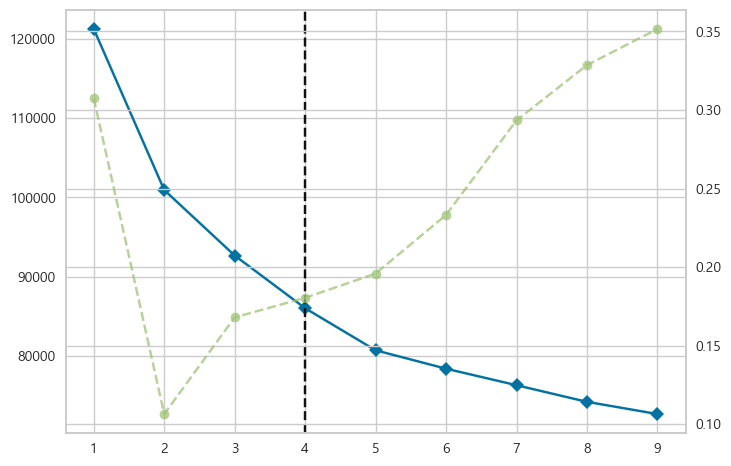

In [33]:
scaler = MinMaxScaler()
train_data_scale = scaler.fit_transform(train_x)
test_data_scale = scaler.transform(test_x)

model = KMeans()
visualizer = KElbowVisualizer(model, k=(1,10))
visualizer.fit(train_data_scale)

In [34]:
k = 4

# 그룹 수, random_state 설정
model = KMeans(n_clusters = k, random_state = 10)

# 정규화된 데이터에 학습
model.fit(train_data_scale)

# 클러스터링 결과 각 데이터가 몇 번째 그룹에 속하는지 저장
train_x['cluster'] = model.fit_predict(train_data_scale)
test_x['cluster'] = model.predict(test_data_scale)

In [35]:
display(test_x.head())
display(train_x.head())

,요일,기상상태,노면상태,사고유형,hour,weekday,day,month,year,gu,dong,road1,road2,holiday,시간대,acci_cnt,acci_cnt2,사망자수_dong_sum,중상자수_dong_sum,경상자수_dong_sum,부상자수_dong_sum,사망자수_cc_sum,중상자수_cc_sum,경상자수_cc_sum,부상자수_cc_sum,serious_ratio,serious_ratio2,연,월,일,시간,도시,구,동,도로형태1,도로형태2,설치개수,cnt,급지구분_1,급지구분_2,급지구분_3,총부상자수,시간별_총부상자수_비율,cluster
0,5,2,0,0,1,5,1,1,2022,6,99,0,3,1.0,0,338,2170,2,91,381,32,43,935,1187,129,0.275148,0.450691,2022,1,1,1,0,6,99,0,3,700.0,5.0,3.0,5.0,3.0,0.483097,0.016890,1
1,5,2,0,0,1,5,1,1,2022,6,168,2,5,1.0,0,492,3957,1,145,484,58,78,1358,2266,466,0.296748,0.362901,2022,1,1,1,0,6,168,2,5,882.0,10.0,0.0,0.0,2.0,0.483097,0.016890,1
2,5,2,0,1,4,5,1,1,2022,6,117,0,3,1.0,0,147,14771,0,43,165,17,60,3889,17343,2013,0.292517,0.267348,2022,1,1,4,0,6,117,0,3,882.0,1.0,3.0,5.0,3.0,0.370835,0.009266,0
3,5,2,0,1,4,5,1,1,2022,6,126,2,5,1.0,0,372,15566,3,74,401,48,74,3416,19030,1926,0.206989,0.224207,2022,1,1,4,0,6,126,2,5,882.0,7.0,0.0,2.0,1.0,0.370835,0.009266,0
4,5,2,0,1,6,5,1,1,2022,1,4,0,3,1.0,0,678,14771,3,148,790,73,60,3889,17343,2013,0.222714,0.267348,2022,1,1,6,0,1,4,0,3,932.0,12.0,0.0,1.0,3.0,0.370835,0.018935,0


,요일,기상상태,노면상태,사고유형,hour,weekday,day,month,year,gu,dong,road1,road2,holiday,시간대,acci_cnt,acci_cnt2,사망자수_dong_sum,중상자수_dong_sum,경상자수_dong_sum,부상자수_dong_sum,사망자수_cc_sum,중상자수_cc_sum,경상자수_cc_sum,부상자수_cc_sum,serious_ratio,serious_ratio2,연,월,일,시간,도시,구,동,도로형태1,도로형태2,설치개수,cnt,급지구분_1,급지구분_2,급지구분_3,총부상자수,시간별_총부상자수_비율,cluster
0,6,2,0,0,0,1,1,1,2019,7,40,2,5,1.0,3,131,3957,3,31,116,28,78,1358,2266,466,0.259542,0.362901,2019,1,1,0,0,7,40,2,5,391.0,2.0,11.0,0.0,0.0,1,0.020904,1
1,6,5,0,0,0,1,1,1,2019,1,4,2,5,1.0,3,678,3957,3,148,790,73,78,1358,2266,466,0.222714,0.362901,2019,1,1,0,0,1,4,2,5,932.0,12.0,0.0,1.0,3.0,0,0.020904,1
2,6,2,0,0,1,1,1,1,2019,6,66,2,5,1.0,0,604,3957,0,145,708,76,78,1358,2266,466,0.240066,0.362901,2019,1,1,1,0,6,66,2,5,473.0,5.0,3.0,5.0,3.0,0,0.016890,1
3,6,2,0,1,2,1,1,1,2019,4,79,2,5,1.0,0,426,15566,1,90,422,67,74,3416,19030,1926,0.213615,0.224207,2019,1,1,2,0,4,79,2,5,534.0,11.0,0.0,9.0,5.0,1,0.013128,2
4,6,2,0,1,4,1,1,1,2019,3,129,2,5,1.0,0,825,15566,3,205,862,112,74,3416,19030,1926,0.252121,0.224207,2019,1,1,4,0,3,129,2,5,2057.0,12.0,0.0,1.0,0.0,0,0.009266,2


In [36]:
print(test_x.shape)
print(train_x.shape)
print(train_y.shape)

(10963, 44)
(39609, 44)
(39609,)


# Model

In [37]:
def rmsle(y_true, y_pred):
    y_true = tf.cast(y_true, tf.float32)
    y_pred = tf.cast(y_pred, tf.float32)
    
    squared_error = tf.square(tf.math.log1p(y_pred) - tf.math.log1p(y_true))

    return tf.sqrt(tf.reduce_mean(squared_error))

def loss_fn(y_true, y_pred):
    return rmsle(y_true, y_pred)

def metric_fn(y_true, y_pred):
    return rmsle(y_true, y_pred)

In [38]:
callbacks_list = [
    tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=30, verbose=2, mode='min',restore_best_weights=True),
    tf.keras.callbacks.ReduceLROnPlateau(monitor='val_loss', factor=0.8, patience=3, min_lr=0.00001),
    tf.keras.callbacks.TerminateOnNaN()
] 

In [39]:
def create_model():
    
    input_layer = tf.keras.Input(shape=(len(train_x.columns), ))
    x = tf.keras.layers.BatchNormalization(epsilon=0.00001)(input_layer)
    x = tf.keras.layers.Dense(16, activation='relu')(x)
    #x = tf.keras.layers.BatchNormalization(epsilon=0.00001)(x)
    x = tf.keras.layers.Dense(32, activation='relu')(x)
    #x = tf.keras.layers.BatchNormalization(epsilon=0.00001)(x)
    output_layer = tf.keras.layers.Dense(1)(x)
    
    model = tf.keras.Model(inputs=input_layer, outputs=output_layer)
    
    model.compile(optimizer=tf.keras.optimizers.Adam(0.001),
                  loss=loss_fn,
                  metrics=[metric_fn]
                  )
    
    return model

model = create_model()
history = model.fit(train_x.astype('float32'), train_y.astype('float32'),
                    epochs=100,
                    callbacks=callbacks_list,
                    validation_split=0.1)


Epoch 1/100


1114/1114 [==============================] - 2s 1ms/step - loss: 0.4864 - metric_fn: 0.4864 - val_loss: 0.4160 - val_metric_fn: 0.4160 - lr: 0.0010
Epoch 2/100
1114/1114 [==============================] - 1s 1ms/step - loss: 0.4330 - metric_fn: 0.4330 - val_loss: 0.4089 - val_metric_fn: 0.4088 - lr: 0.0010
Epoch 3/100
1114/1114 [==============================] - 1s 1ms/step - loss: 0.4280 - metric_fn: 0.4280 - val_loss: 0.4078 - val_metric_fn: 0.4078 - lr: 0.0010
Epoch 4/100
1114/1114 [==============================] - 1s 1ms/step - loss: 0.4267 - metric_fn: 0.4267 - val_loss: 0.4071 - val_metric_fn: 0.4071 - lr: 0.0010
Epoch 5/100
1114/1114 [==============================] - 1s 1ms/step - loss: 0.4251 - metric_fn: 0.4251 - val_loss: 0.4054 - val_metric_fn: 0.4054 - lr: 0.0010
Epoch 6/100
1114/1114 [==============================] - 1s 1ms/step - loss: 0.4248 - metric_fn: 0.4248 - val_loss: 0.4036 - val_metric_fn: 0.4035 - lr: 0.0010
Epoch 7/100
1114/1114 [==============

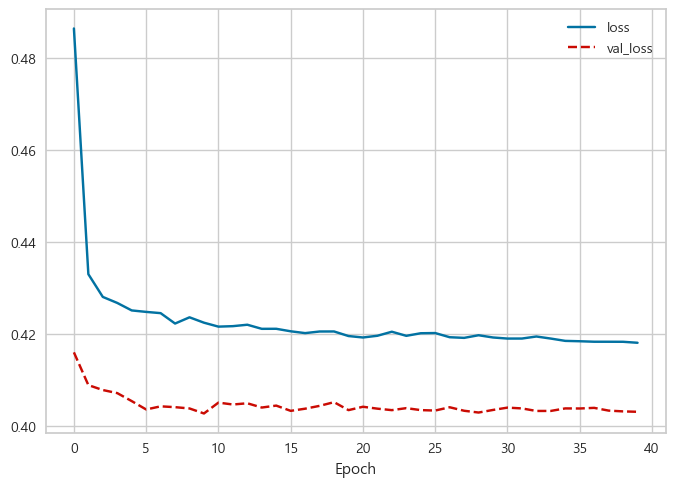

In [40]:
# train loss, val loss 시각화
import matplotlib.pyplot as plt

plt.plot(history.history['loss'], 'b-', label='loss')
plt.plot(history.history['val_loss'], 'r--', label='val_loss')
plt.xlabel('Epoch')
plt.legend()
plt.show()

In [41]:
sample_submission = pd.read_csv('../open/sample_submission.csv')

sample_submission["ECLO"] = model.predict(test_x.astype('float32'))

343/343 [==============================] - 0s 691us/step


In [42]:
sample_submission

,ID,ECLO
0,ACCIDENT_39609,4.114569
1,ACCIDENT_39610,3.672591
2,ACCIDENT_39611,4.441924
3,ACCIDENT_39612,4.181569
4,ACCIDENT_39613,4.457203
...,...,...
10958,ACCIDENT_50567,3.902726
10959,ACCIDENT_50568,4.270216
10960,ACCIDENT_50569,4.430731
10961,ACCIDENT_50570,4.198217


In [44]:
sample_submission.describe()

,ECLO
count,10963.000000
mean,3.764020
std,0.345935
min,2.347612
25%,3.566115
50%,3.785786
75%,3.999219
max,6.635020


In [45]:
sample_submission.to_csv("../Sub/tensorflow_1.csv", index=False)